In [1]:
import torch
from torch import nn
import pickle as pkl

In [2]:
def MyMax(x):
    r = .2
    if x>0: return 1
    if x<-r: return 0
    return 1+x/r


In [3]:
GPU = True

def numpy2torch(x, dtype='float32'):
    'Converts a numpy array to a torch array'
    x = torch.from_numpy(x.astype(dtype))
    if GPU:
        x = x.cuda()
    return x

def torch2numpy(x):
    'Converts a torch array to a numpy array'
    return x.detach().cpu().numpy()

# Abbreviation for converting functions
t2np = torch2numpy
np2t = numpy2torch

In [28]:
act = torch.nn.GELU()
act = torch.relu
softmax = torch.log_softmax

smf = 10

class _alt_DecisionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.L1 = nn.Linear(36*2+1, 400)
        self.L2 = nn.Linear(400, 400)
        self.L3 = nn.Linear(400, 400)
        self.L4 = nn.Linear(400, 400)
        self.L5 = nn.Linear(400, 36)
        if GPU: self.cuda()
    def forward(self, x, mask):
        y = torch.cat([x, torch.zeros(len(x), 400-(36*2+1)).cuda()], dim=-1)
        y += act(self.L1(x))
        y += act(self.L2(y))
        #y += act(self.L3(y))
        #y += act(self.L4(y))
        y = self.L5(y)
        
        #y=  x[:,-36:]*100   ## toggle for redirecting cheat input to output
        
        ##y = self.L1(x)
        ##y = self.L5(y)
        
        y = y*mask-10**10*(1-mask)
        #y = y+x[:,:36]
        y = softmax(smf*y, -1)
        #return x[:,:36]  ## reproduce Ps
        #return softmax(x[:,-36:]*100, -1) ## cheating if target is in these channels
        return y

class DecisionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.L1 = nn.Linear(3, 100)
        self.L2 = nn.Linear(50, 50)
        self.L3 = nn.Linear(100, 1)
        if GPU: self.cuda()
    def forward(self, x, mask):
        b = len(x)
        x = x.reshape(b, 3, 36)
        x = x.transpose(1,2)
        x = x.reshape(b*36, 3)
        
        y = act(self.L1(x))
        #y = act(self.L2(y))
        y = self.L3(y)
        
        #y=  x[:,-36:]*100   ## toggle for redirecting cheat input to output
        
        ##y = self.L1(x)
        ##y = self.L5(y)
        
        y = y.view(b, -1)
        y = y*mask-10**10*(1-mask)
        y = softmax(smf*y, -1)
        return y
    
    def single(self, x):
        y = act(self.L1(x))
        #y = act(self.L2(y))
        y = self.L3(y)
        return y
    
net = DecisionNet()

In [30]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.999))
bnum = 50
losses = []
winolds, winnews = [], []

for epoch in range(1,10000):
    with open(f'F:\$Daten\hex_mcts_data\mcts_treedata{100*(1+epoch%81)}.pkl', 'rb') as f:
        history = pkl.load(f)
    print(epoch)
    mbatches = [ history[i*bnum:(i+1)*bnum] for i in range(len(history)//bnum) ]
    for imb, mb in enumerate(mbatches):
        
        rlen= lambda : np.random.choice([0,1,1,1, 1]) #np.random.randint(1,10)
        
        Ps = np.array([ P for (board0, P, V, Wa) in mb ], dtype='float32')
        Vs = np.array([ [V] for (board0, P, V, Wa) in mb ])
        Ws = np.array([ [np.mean(Wa[k][:rlen()]) for k in range(36)] for (board0, P, V, Wa) in mb ])
        mask = np.array([ [ 0 if P[k] is None else 1. for k in range(36) ] for (board0, P, V, Wa) in mb ])
        endWs = np.array( [ [np.mean(Wa[k]) for k in range(36)] for (board0, P, V, Wa) in mb ] )
        target = mask*np.array( [ [ MyMax(endWs[b,k]-endWs[b].max()) for k in range(36) ] for b in range(bnum) ] )
        
        '''
        perm = np.random.choice(range(36), 36, replace=False)
        Ps = Ps[:,perm]
        Ws = Ws[:,perm]
        mask = mask[:,perm]
        endWs = endWs[:,perm]
        target = target[:,perm]''';
        
        Ws = np.nan_to_num(Ws) # mean über empty liste macht nan
        
        Ns = (Ws != 0.)
        Ws = Ws#-Vs[:]
        #print(Ns, Ws)
        
        target = endWs
        
        inpt = np.concatenate([np.log(np.nan_to_num(Ps)+1e-5), Ws, Ns], -1) # mit cheating wenn Ws über viele gemittelt ist (siehe definition)

        logPsnew = net(np2t(inpt), np2t(mask))
        
        
        loss = torch.mean(-(logPsnew*np2t(target)))
        #loss += torch.mean((-(logPsnew*np2t(target)))**2)

        
        Psold = np.nan_to_num(Ps)
        Psnew = np.exp(t2np(logPsnew))
        winold = np.sum(Psold*target) / bnum
        winnew = np.sum(Psnew*target) / bnum
        
        if imb != 0:
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            losses.append(loss.item())
            winolds.append(winold)
            winnews.append(winnew)
            
        else:
            print('Val:', loss.item(), winnew-winold )
        
    print(np.mean(losses), np.mean(winolds), np.mean(winnews))
    losses = []

1
Val: -402.7545166015625 -0.030475835757731662
-637.5521240234375 0.5023260976129894 0.3910832773553969
2
Val: -389.6529235839844 0.019695472902015676
-183.6087646484375 0.531539531205805 0.5048523117384663
3
Val: -466.72802734375 0.0037836933980780474
-442.8950500488281 0.5331222441377782 0.5195475075101428
4
Val: -78.51625061035156 0.027785120940902686
-374.6712341308594 0.508703536685999 0.48430984232439334
5
Val: -57.90904235839844 -0.005394982709218232
-319.4054870605469 0.5145196159423686 0.5000707143339411
6
Val: -189.48101806640625 0.0054592526361547655
-361.79510498046875 0.5233180852742108 0.5166225928792703
7
Val: -20.0705623626709 0.008096947173262092
-62.647430419921875 0.5465346951078542 0.5464558005754236
8
Val: -447.2711181640625 -0.06044975472760894
-606.3174438476562 0.5393497695730998 0.5401756138132963
9
Val: -306.1908264160156 0.037374823704888205
-714.4660034179688 0.5296625500199373 0.5236920889056784
10
Val: -332.6959228515625 -0.10140205452861362
-277.63293457

80
Val: -145.18077087402344 0.038628834994996475
-438.6131286621094 0.5550841173932362 0.5464778502788535
81
Val: -321.5547180175781 0.019048722116750127
-316.53179931640625 0.5546134822093792 0.5461402920802083
82
Val: -392.0427551269531 -0.038373029186965835
-714.0146484375 0.5539758311777159 0.544306659896091
83
Val: -358.14501953125 -0.022416060843953645
-173.7054901123047 0.5540574833900159 0.5438821617541035
84
Val: -545.6477661132812 -0.05585029195356983
-461.7432861328125 0.5538459379925363 0.5434551510556611
85
Val: -94.4668960571289 0.025947510318468425
-372.4518737792969 0.5524530141847496 0.5416855247230888
86
Val: -7.993233680725098 0.027577669433300867
-325.8143615722656 0.5522824434729251 0.5416229866902212
87
Val: -189.9032440185547 0.010498959093943494
-334.88189697265625 0.5524551789724711 0.5422537500789576
88
Val: -69.39649200439453 0.07240206831399981
-65.57959747314453 0.5539708514172124 0.5443153976566758
89
Val: -391.2762451171875 -0.06327221923323889
-502.13253

158
Val: -80.99065399169922 0.027420559597525984
-542.739501953125 0.5557079020419854 0.5463117178554887
159
Val: -190.63710021972656 0.021578881294055052
-493.3673095703125 0.5556782735096947 0.546239392611519
160
Val: -14.348695755004883 0.0023709618959830703
-673.8271484375 0.5549367544799657 0.5451792652442412
161
Val: -104.3887710571289 0.024459368755064048
-343.21966552734375 0.5548473382013578 0.5450793863373185
162


KeyboardInterrupt: 

In [ ]:
act = torch.nn.GELU()
act = torch.relu

smf = 1

In [122]:
mask[0]

array([0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       1., 1.])

In [123]:
Ps[0]

array([       nan, 0.00697356, 0.22073853, 0.08514267,        nan,
       0.04552318,        nan,        nan, 0.00877801, 0.0062341 ,
              nan, 0.00686964,        nan, 0.00789609, 0.00727939,
       0.16936372, 0.14076771,        nan, 0.01509799, 0.00410301,
       0.01625006,        nan, 0.08420771,        nan,        nan,
       0.0062824 , 0.00465523,        nan, 0.00346618, 0.02109546,
              nan, 0.00848524, 0.00883556, 0.03133814, 0.0073799 ,
       0.07438751], dtype=float32)

In [134]:
Ws[0]

array([0.9994821 , 0.99999702, 0.        , 0.        , 0.99999076,
       0.9988222 , 0.99999845, 0.98933715, 0.94694406, 0.        ,
       0.99902815, 0.99995887, 0.99418014, 0.99960256, 0.        ,
       0.        , 0.99997866, 0.99755365, 0.        , 0.99999881,
       0.99968779, 0.99998587, 0.        , 0.        , 0.998896  ,
       0.99987692, 0.99994862, 0.99987459, 0.        , 0.99512315,
       0.        , 0.99947321, 0.07233871, 0.99996608, 0.99938256,
       0.        ])

In [140]:
endWs[0]

array([ 0.        , -0.64128473, -0.49418454, -0.47279545,  0.        ,
        0.80002599, -0.42922729,  0.        , -0.5859421 ,  0.        ,
        0.59823795,  0.17825203, -0.44716141, -0.36815029,  0.13383544,
       -0.46993589, -0.60687143,  0.        , -0.23645694, -0.54759051,
        0.        , -0.08807594,  0.        , -0.18431159, -0.16034306,
       -0.5689493 , -0.69200326,  0.        ,  0.        , -0.50402216,
       -0.44408971,  0.        , -0.47548286,  0.05982454,  0.04704331,
       -0.5611708 ])

In [141]:
target[0]

array([0.30504898, 0.83837558, 0.34218216, 0.5334624 , 0.        ,
       0.        , 0.64916235, 0.50254517, 0.        , 0.32525796,
       0.        , 0.54694931, 0.85999257, 0.57932905, 0.        ,
       0.57220142, 0.        , 0.83595856, 0.        , 0.25223966,
       0.76842651, 0.        , 0.59387032, 0.65372317, 0.44915645,
       0.69133234, 0.        , 0.83451703, 0.93861558, 0.34759294,
       0.        , 0.55909335, 0.4363062 , 0.03968625, 0.40029507,
       0.25679546])

In [142]:
Psnew[0]

array([3.9688197e-07, 1.0538726e-01, 1.1585091e-28, 1.4204151e-06,
       0.0000000e+00, 0.0000000e+00, 4.2222276e-02, 2.6814150e-20,
       0.0000000e+00, 3.6588408e-29, 0.0000000e+00, 1.1090896e-28,
       3.1140965e-01, 3.1948291e-22, 0.0000000e+00, 1.6358018e-17,
       0.0000000e+00, 2.4235821e-03, 0.0000000e+00, 7.3305060e-26,
       4.3004990e-04, 0.0000000e+00, 6.0970025e-21, 5.6180048e-12,
       7.5645786e-28, 3.1088810e-21, 0.0000000e+00, 8.6485565e-02,
       4.5164022e-01, 4.7336347e-26, 0.0000000e+00, 4.1106068e-22,
       1.1864186e-25, 8.2478687e-30, 9.9650166e-21, 7.1987304e-28],
      dtype=float32)

In [143]:
Psold[0]

array([0.01863351, 0.5544135 , 0.0035383 , 0.01996901, 0.        ,
       0.        , 0.00310223, 0.00285983, 0.        , 0.00351584,
       0.        , 0.00320961, 0.03774713, 0.01835756, 0.        ,
       0.01022001, 0.        , 0.0150869 , 0.        , 0.00973935,
       0.01738133, 0.        , 0.00320576, 0.10711414, 0.01586496,
       0.02238185, 0.        , 0.05909768, 0.00969266, 0.00930897,
       0.        , 0.00838712, 0.00771946, 0.00452089, 0.01964393,
       0.01253155], dtype=float32)

In [129]:
np.mean(target*Psnew), np.mean(target*Psold)

(0.01441239688567771, 0.01129678079281596)

In [84]:
logPsnew[0]

tensor([-1.0000e+11, -6.4457e+00, -1.1443e+00, -6.5418e+00, -1.3005e+01,
        -1.0000e+11, -1.0729e+01, -6.3980e+00, -7.3192e-01, -1.3727e+01,
        -1.3422e+01, -3.4019e+00, -1.0488e+01, -1.4384e+01, -7.3815e+00,
        -1.0000e+11, -1.4140e+01, -2.3492e+00, -8.2799e+00, -3.3058e+00,
        -4.5183e+00, -1.0000e+11, -9.9114e+00, -8.6766e+00, -8.0539e+00,
        -7.3470e+00, -1.4866e+01, -6.4096e+00, -1.3763e+01, -5.1723e+00,
        -7.9511e+00, -4.7309e+00, -1.0000e+11, -1.1292e+01, -1.0000e+11,
        -6.9891e+00], device='cuda:0', grad_fn=<SelectBackward>)

In [200]:
warr = np.linspace(-1, 1, 100)
parr = np.linspace(0.01, 1, 100)

result = np.zeros((100, 100))

for i in range(100):
    for j in range(100):
        w, p = warr[i], parr[j]
        inpt = np2t(np.array([[np.log(p+1e-12), w]]))
        outpt = net.single(inpt).item()
        result[i,j] = outpt
    

<AxesSubplot:>

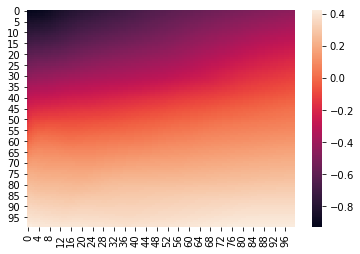

In [201]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(result)

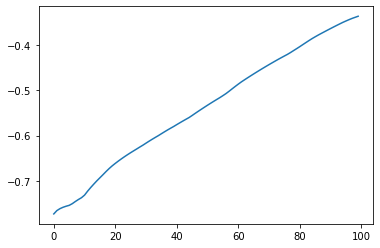

In [208]:
plt.plot(result[10])

In [187]:
smf

10

In [4]:
import numpy as np

def oneturn(cpuct, Nmax):

    ratings = []
    bnum = 1
    for epoch in range(1,10000):
        with open(f'F:\$Daten\hex_mcts_data\mcts_treedata{100*(1+epoch%81)}.pkl', 'rb') as f:
            history = pkl.load(f)
        #print(epoch)
        mbatches = [ history[i*bnum:(i+1)*bnum] for i in range(len(history)//bnum) ]
        for imb, mb in enumerate(mbatches):
            rint= lambda : np.random.randint(5,10)
            Ps = np.array([ P for (board0, P, V, Wa) in mb ], dtype='float32')
            Vs = np.array([ [V] for (board0, P, V, Wa) in mb ])
            Ws = np.array([ [np.mean(Wa[k][:rint()]) for k in range(36)] for (board0, P, V, Wa) in mb ])
            Was = [ Wa for (board0, P, V, Wa) in mb ]
            mask = np.array([ [ 0 if P[k] is None else 1. for k in range(36) ] for (board0, P, V, Wa) in mb ])
            endWs = np.array( [ [np.mean(Wa[k]) for k in range(36)] for (board0, P, V, Wa) in mb ] )
            target = mask*np.array( [ [ MyMax(endWs[b,k]-endWs[b].max()) for k in range(36) ] for b in range(bnum) ] )
            if not all([(len(Was[k][j])<=1) == (mask[k][j]==0) for k in range(bnum) for j in range(36)]):
                #print([len(Was[0][j]) for j in range(36)], mask[0])
                continue

            target = endWs

            '''
            def getPs(Ws):
                inpt = np.concatenate([np.log(np.nan_to_num(Ps)+1e-5), Ws], -1)
                logPsnew = net(np2t(inpt), np2t(mask))
                _Psnew = np.exp(t2np(logPsnew))
                return _Psnew'''

            Psold = np.nan_to_num(Ps)
            #Psnew = getPs(Ws)
            Psnew = [0]

            # spiel spielen
            Ps, Vs, Ws, endWs, mask, Psold, Psnew, Was, target = Ps[0], Vs[0], Ws[0], endWs[0], mask[0], Psold[0], Psnew[0], Was[0], target[0]
            Q0 = 0.

            PPs = Psold # !

            N = 0
            Na = np.zeros(36, dtype='int')
            Qa = Q0*np.ones(36)
            ownQ = []
            while True:
                Ulist = [cpuct(Qa[i], PPs[i], N, Na[i]) if mask[i]==1 else -np.Inf for i in range(36)]
                k = np.argmax(Ulist)
                Na[k] += 1
                N += 1
                Qa[k] = np.mean(Was[k][:Na[k]])
                ownQ.append(Was[k][Na[k]])
                ##PPs = getPs(Qa[None])
                if N >= Nmax:
                    #k = np.argmax(Na)
                    k = np.argmax(Qa - .5/np.sqrt(Na+1e-2))
                    break

            #ratings.append(target[k])
            ratings += [ -abs(max(endWs)-np.mean(ownQ)) ]
            if len(ratings)>200:
                #print(np.mean(ratings))
                return np.mean(ratings)
                ratings = []

In [7]:
funcs = [lambda Qa, Pa, N, Na: Qa + c*Pa/(np.sqrt(Na)+1),
    lambda Qa, Pa, N, Na: Qa + c*Pa*(np.sqrt(N)+1e-8)/(Na+1),
    lambda Qa, Pa, N, Na: Qa + c*Pa/(np.sqrt(Na)+1e-8),
    lambda Qa, Pa, N, Na: Qa + c*Pa/(Na+1),
        ]

#for N in [2, 5, 10, 20, 50, 100]:
for N in [80]:
    print('\nN =', N)
    for f in funcs:
        best = -np.Inf
        for c in [.5, 1, 4, 10]:
            rating = oneturn(f, N)
            if rating > best:
                best=rating
                cbest = c
            #print(rating)
        print(best, 'with c =', cbest)
        


N = 80
-0.13526915124577085 with c = 10


KeyboardInterrupt: 

In [5]:
from ray import tune

def train_function(config):
    c1, c2, c3 = config['c1'], config['c2'], config['c3']#, config['N']
    #print(config)
    f = lambda Qa, Pa, N, Na: Qa + c1*Pa/(np.sqrt(Na)+1) + c2*Pa*(np.sqrt(N)+1e-8)/(Na+1) + c3*Pa/(Na+1)
    N5 = oneturn(f, 5)
    N20 = oneturn(f, 20)
    N50 = oneturn(f, 50)
    N80 = oneturn(f, 80)
    tune.report(N5=N5, N20=N20, N50=N50, N80=N80, sum=N5+N20+N50+N80)

analysis = tune.run(train_function, config={
            'c1': tune.grid_search([0, .5, 1, 4, 10]),
            'c2': tune.grid_search([0, .5, 1, 4, 10]),
            'c3': tune.grid_search([0, .5, 1, 4, 10]),
            #'N': tune.grid_search([5, 20, 50])
})

2021-03-25 01:20:06,083	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
2021-03-25 01:20:20,378	WARNING function_runner.py:541 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-03-25 01:20:20,575	WARNING tune.py:411 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, set tune.run(resources_per_trial={'gpu': 1}...) which allows Tune to expose 1 GPU to each trial. You can also override `Trainable.default_resource_request` if using the Trainable API.
2021-03-25 01:20:20,657	ERROR syncer.py:72 -- Log sync requires rsync to be installed.


Trial name,status,loc,c1,c2,c3
train_function_e22b1_00000,RUNNING,,0,0,0


2021-03-25 01:21:24,761	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\.tmp_generator' -> 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\basic-variant-state-2021-03-25_01-20-20.json'


Result for train_function_e22b1_00000:
  N20: -0.40374762874400505
  N5: -0.5235649379378955
  N50: -0.3336897159842918
  N80: -0.3086200648237128
  date: 2021-03-25_01-21-24
  done: false
  experiment_id: 7c2e72455f2c4201886a3e93efc18ab6
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 12936
  sum: -1.5696223474899051
  time_since_restore: 62.274290561676025
  time_this_iter_s: 62.274290561676025
  time_total_s: 62.274290561676025
  timestamp: 1616631684
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00000
  


Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00000,RUNNING,192.168.2.37:12936,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369
train_function_e22b1_00001,RUNNING,,0.5,0,0,,,,,
train_function_e22b1_00002,RUNNING,,1,0,0,,,,,
train_function_e22b1_00003,RUNNING,,4,0,0,,,,,
train_function_e22b1_00004,RUNNING,,10,0,0,,,,,
train_function_e22b1_00005,RUNNING,,0,0.5,0,,,,,
train_function_e22b1_00006,RUNNING,,0.5,0.5,0,,,,,
train_function_e22b1_00007,RUNNING,,1,0.5,0,,,,,
train_function_e22b1_00008,PENDING,,4,0.5,0,,,,,


Result for train_function_e22b1_00000:
  N20: -0.40374762874400505
  N5: -0.5235649379378955
  N50: -0.3336897159842918
  N80: -0.3086200648237128
  date: 2021-03-25_01-21-24
  done: true
  experiment_id: 7c2e72455f2c4201886a3e93efc18ab6
  experiment_tag: 0_c1=0,c2=0,c3=0
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 12936
  sum: -1.5696223474899051
  time_since_restore: 62.274290561676025
  time_this_iter_s: 62.274290561676025
  time_total_s: 62.274290561676025
  timestamp: 1616631684
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00000
  
Result for train_function_e22b1_00005:
  N20: -0.2084716445025512
  N5: -0.244590149462605
  N50: -0.1544577055537462
  N80: -0.14305295359062808
  date: 2021-03-25_01-21-25
  done: false
  experiment_id: 0ee2d203ca2f46178d02004984150f6e
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 7256
  sum: -0.7505724531095305
  time_since_restore: 62.02765679

2021-03-25 01:22:35,124	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\.tmp_generator' -> 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\basic-variant-state-2021-03-25_01-20-20.json'


Result for train_function_e22b1_00012:
  N20: -0.19523245117536792
  N5: -0.24369702216157726
  N50: -0.1433039221741817
  N80: -0.12946846033164877
  date: 2021-03-25_01-22-34
  done: false
  experiment_id: 82d8e5c52c6a4b288fdbf6b659f489ca
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 3052
  sum: -0.7117018558427757
  time_since_restore: 58.83338141441345
  time_this_iter_s: 58.83338141441345
  time_total_s: 58.83338141441345
  timestamp: 1616631754
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00012
  


Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00008,RUNNING,,4,0.5,0,,,,,
train_function_e22b1_00009,RUNNING,,10,0.5,0,,,,,
train_function_e22b1_00010,RUNNING,,0,1,0,,,,,
train_function_e22b1_00011,RUNNING,,0.5,1,0,,,,,
train_function_e22b1_00012,RUNNING,192.168.2.37:3052,1,1,0,1,58.8334,-0.243697,-0.195232,-0.143304
train_function_e22b1_00013,RUNNING,,4,1,0,,,,,
train_function_e22b1_00014,RUNNING,,10,1,0,,,,,
train_function_e22b1_00015,RUNNING,,0,4,0,,,,,
train_function_e22b1_00016,PENDING,,0.5,4,0,,,,,
train_function_e22b1_00000,TERMINATED,,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369


Result for train_function_e22b1_00012:
  N20: -0.19523245117536792
  N5: -0.24369702216157726
  N50: -0.1433039221741817
  N80: -0.12946846033164877
  date: 2021-03-25_01-22-34
  done: true
  experiment_id: 82d8e5c52c6a4b288fdbf6b659f489ca
  experiment_tag: 12_c1=1,c2=1,c3=0
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 3052
  sum: -0.7117018558427757
  time_since_restore: 58.83338141441345
  time_this_iter_s: 58.83338141441345
  time_total_s: 58.83338141441345
  timestamp: 1616631754
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00012
  
Result for train_function_e22b1_00011:
  N20: -0.19874338001992323
  N5: -0.2425117578093612
  N50: -0.14515380450204918
  N80: -0.13110233871630586
  date: 2021-03-25_01-22-35
  done: false
  experiment_id: 23929d9ccfc4410980dc02ff1f097d8b
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 12556
  sum: -0.7175112810476395
  time_since_restore: 59.77237

Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00008,RUNNING,,4,0.5,0,,,,,
train_function_e22b1_00009,RUNNING,192.168.2.37:5900,10,0.5,0,1,65.7823,-0.238753,-0.188725,-0.149505
train_function_e22b1_00010,RUNNING,,0,1,0,,,,,
train_function_e22b1_00013,RUNNING,,4,1,0,,,,,
train_function_e22b1_00014,RUNNING,,10,1,0,,,,,
train_function_e22b1_00015,RUNNING,,0,4,0,,,,,
train_function_e22b1_00016,RUNNING,,0.5,4,0,,,,,
train_function_e22b1_00017,RUNNING,,1,4,0,,,,,
train_function_e22b1_00018,PENDING,,4,4,0,,,,,
train_function_e22b1_00000,TERMINATED,,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369


Result for train_function_e22b1_00009:
  N20: -0.18872455145729755
  N5: -0.2387530981591331
  N50: -0.14950520643178358
  N80: -0.13480411040394247
  date: 2021-03-25_01-22-41
  done: true
  experiment_id: c7b3cd17ccb4458b96eaa974cfcd3b0d
  experiment_tag: 9_c1=10,c2=0.5,c3=0
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 5900
  sum: -0.7117869664521567
  time_since_restore: 65.78225517272949
  time_this_iter_s: 65.78225517272949
  time_total_s: 65.78225517272949
  timestamp: 1616631761
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00009
  
Result for train_function_e22b1_00008:
  N20: -0.1887953718766218
  N5: -0.23906235121419028
  N50: -0.14655771945687993
  N80: -0.13168547321280694
  date: 2021-03-25_01-22-41
  done: false
  experiment_id: e31f5da937ca4e1f9fe88c9b8a1a2959
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 14296
  sum: -0.7061009157604989
  time_since_restore: 65.725

2021-03-25 01:23:48,919	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\.tmp_generator' -> 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\basic-variant-state-2021-03-25_01-20-20.json'


Result for train_function_e22b1_00016:
  N20: -0.19991885566814796
  N5: -0.23858195231735396
  N50: -0.17521656502464755
  N80: -0.16370155443717554
  date: 2021-03-25_01-23-48
  done: false
  experiment_id: e0f70a65cf9d472e932745b8ae03f50c
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 3028
  sum: -0.7774189274473251
  time_since_restore: 63.68116855621338
  time_this_iter_s: 63.68116855621338
  time_total_s: 63.68116855621338
  timestamp: 1616631828
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00016
  


Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00016,RUNNING,192.168.2.37:3028,0.5,4,0,1,63.6812,-0.238582,-0.199919,-0.175217
train_function_e22b1_00017,RUNNING,,1,4,0,,,,,
train_function_e22b1_00018,RUNNING,,4,4,0,,,,,
train_function_e22b1_00019,RUNNING,,10,4,0,,,,,
train_function_e22b1_00020,RUNNING,,0,10,0,,,,,
train_function_e22b1_00021,RUNNING,,0.5,10,0,,,,,
train_function_e22b1_00022,RUNNING,,1,10,0,,,,,
train_function_e22b1_00023,RUNNING,,4,10,0,,,,,
train_function_e22b1_00024,PENDING,,10,10,0,,,,,
train_function_e22b1_00000,TERMINATED,,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369


Result for train_function_e22b1_00016:
  N20: -0.19991885566814796
  N5: -0.23858195231735396
  N50: -0.17521656502464755
  N80: -0.16370155443717554
  date: 2021-03-25_01-23-48
  done: true
  experiment_id: e0f70a65cf9d472e932745b8ae03f50c
  experiment_tag: 16_c1=0.5,c2=4,c3=0
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 3028
  sum: -0.7774189274473251
  time_since_restore: 63.68116855621338
  time_this_iter_s: 63.68116855621338
  time_total_s: 63.68116855621338
  timestamp: 1616631828
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00016
  
Result for train_function_e22b1_00017:
  N20: -0.20085910401389834
  N5: -0.23960939519314015
  N50: -0.17620868447085056
  N80: -0.16510833704600095
  date: 2021-03-25_01-23-50
  done: false
  experiment_id: 11d13918b83540eeb254d98937a05432
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 5080
  sum: -0.78178552072389
  time_since_restore: 65.2472

Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00020,RUNNING,,0,10,0,,,,,
train_function_e22b1_00021,RUNNING,,0.5,10,0,,,,,
train_function_e22b1_00022,RUNNING,192.168.2.37:5612,1,10,0,1,63.9823,-0.258809,-0.253372,-0.243628
train_function_e22b1_00023,RUNNING,,4,10,0,,,,,
train_function_e22b1_00024,RUNNING,,10,10,0,,,,,
train_function_e22b1_00025,RUNNING,,0,0,0.5,,,,,
train_function_e22b1_00026,RUNNING,,0.5,0,0.5,,,,,
train_function_e22b1_00027,RUNNING,,1,0,0.5,,,,,
train_function_e22b1_00028,PENDING,,4,0,0.5,,,,,
train_function_e22b1_00000,TERMINATED,,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369


Result for train_function_e22b1_00022:
  N20: -0.25337199126682913
  N5: -0.2588094708124918
  N50: -0.2436275158369551
  N80: -0.23779604702454715
  date: 2021-03-25_01-23-55
  done: true
  experiment_id: a1153255efdd4d5da80f8897acaf8610
  experiment_tag: 22_c1=1,c2=10,c3=0
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 5612
  sum: -0.9936050249408231
  time_since_restore: 63.98229432106018
  time_this_iter_s: 63.98229432106018
  time_total_s: 63.98229432106018
  timestamp: 1616631835
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00022
  
Result for train_function_e22b1_00023:
  N20: -0.25338111451723616
  N5: -0.2636588335893317
  N50: -0.244123666682961
  N80: -0.23784716801566771
  date: 2021-03-25_01-23-56
  done: false
  experiment_id: 10f620e85f614676a9432a20ef385fe8
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 12688
  sum: -0.9990107828051966
  time_since_restore: 64.1573076

2021-03-25 01:23:59,318	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\.tmp_generator' -> 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\basic-variant-state-2021-03-25_01-20-20.json'


Result for train_function_e22b1_00021:
  N20: -0.2537598547469917
  N5: -0.25780164360052343
  N50: -0.24370291023353663
  N80: -0.23818213000617872
  date: 2021-03-25_01-23-59
  done: false
  experiment_id: f5ac212f51ed475bb57b6f383e2c8eca
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 5204
  sum: -0.9934465385872305
  time_since_restore: 67.44128227233887
  time_this_iter_s: 67.44128227233887
  time_total_s: 67.44128227233887
  timestamp: 1616631839
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00021
  
Result for train_function_e22b1_00021:
  N20: -0.2537598547469917
  N5: -0.25780164360052343
  N50: -0.24370291023353663
  N80: -0.23818213000617872
  date: 2021-03-25_01-23-59
  done: true
  experiment_id: f5ac212f51ed475bb57b6f383e2c8eca
  experiment_tag: 21_c1=0.5,c2=10,c3=0
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 5204
  sum: -0.9934465385872305
  time_since_restore: 67.441

2021-03-25 01:25:01,561	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\.tmp_generator' -> 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\basic-variant-state-2021-03-25_01-20-20.json'


Result for train_function_e22b1_00024:
  N20: -0.2533886413543527
  N5: -0.2755637027171781
  N50: -0.24317796589127455
  N80: -0.23892109319795155
  date: 2021-03-25_01-25-01
  done: false
  experiment_id: b1b012dfa63943a496f11a9e70e93ea5
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 5040
  sum: -1.011051403160757
  time_since_restore: 64.78445839881897
  time_this_iter_s: 64.78445839881897
  time_total_s: 64.78445839881897
  timestamp: 1616631901
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00024
  


Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00024,RUNNING,192.168.2.37:5040,10,10,0,1,64.7845,-0.275564,-0.253389,-0.243178
train_function_e22b1_00025,RUNNING,,0,0,0.5,,,,,
train_function_e22b1_00026,RUNNING,,0.5,0,0.5,,,,,
train_function_e22b1_00027,RUNNING,,1,0,0.5,,,,,
train_function_e22b1_00028,RUNNING,,4,0,0.5,,,,,
train_function_e22b1_00029,RUNNING,,10,0,0.5,,,,,
train_function_e22b1_00030,RUNNING,,0,0.5,0.5,,,,,
train_function_e22b1_00031,RUNNING,,0.5,0.5,0.5,,,,,
train_function_e22b1_00032,PENDING,,1,0.5,0.5,,,,,
train_function_e22b1_00000,TERMINATED,,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369


Result for train_function_e22b1_00024:
  N20: -0.2533886413543527
  N5: -0.2755637027171781
  N50: -0.24317796589127455
  N80: -0.23892109319795155
  date: 2021-03-25_01-25-01
  done: true
  experiment_id: b1b012dfa63943a496f11a9e70e93ea5
  experiment_tag: 24_c1=10,c2=10,c3=0
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 5040
  sum: -1.011051403160757
  time_since_restore: 64.78445839881897
  time_this_iter_s: 64.78445839881897
  time_total_s: 64.78445839881897
  timestamp: 1616631901
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00024
  
Result for train_function_e22b1_00025:
  N20: -0.2105916278241176
  N5: -0.24646053818576424
  N50: -0.16224972305157995
  N80: -0.15370144651032186
  date: 2021-03-25_01-25-08
  done: false
  experiment_id: 102d5eb3064e45bbb5235c522bc5b2d1
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 396
  sum: -0.7730033355717836
  time_since_restore: 67.6944255

Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00025,RUNNING,192.168.2.37:396,0,0,0.5,1,67.6944,-0.246461,-0.210592,-0.16225
train_function_e22b1_00026,RUNNING,,0.5,0,0.5,,,,,
train_function_e22b1_00027,RUNNING,,1,0,0.5,,,,,
train_function_e22b1_00028,RUNNING,,4,0,0.5,,,,,
train_function_e22b1_00029,RUNNING,,10,0,0.5,,,,,
train_function_e22b1_00030,RUNNING,,0,0.5,0.5,,,,,
train_function_e22b1_00031,RUNNING,,0.5,0.5,0.5,,,,,
train_function_e22b1_00032,RUNNING,,1,0.5,0.5,,,,,
train_function_e22b1_00033,PENDING,,4,0.5,0.5,,,,,
train_function_e22b1_00000,TERMINATED,,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369


Result for train_function_e22b1_00028:
  N20: -0.18958718644623507
  N5: -0.23813902642034618
  N50: -0.14643427226689038
  N80: -0.13868202455831075
  date: 2021-03-25_01-25-08
  done: false
  experiment_id: e15e2ef639bf4b71af994196d29bfb73
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 12388
  sum: -0.7128425096917823
  time_since_restore: 66.67636632919312
  time_this_iter_s: 66.67636632919312
  time_total_s: 66.67636632919312
  timestamp: 1616631908
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00028
  
Result for train_function_e22b1_00027:
  N20: -0.20233251393364057
  N5: -0.2434317036320248
  N50: -0.1564024441961846
  N80: -0.14914251218062188
  date: 2021-03-25_01-25-08
  done: false
  experiment_id: 9d76bff4cb5b4bac9bee93469386e3e2
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 1820
  sum: -0.7513091739424719
  time_since_restore: 67.3384358882904
  time_this_iter_s: 67.338

2021-03-25 01:26:03,444	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\.tmp_generator' -> 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\basic-variant-state-2021-03-25_01-20-20.json'


Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00032,RUNNING,192.168.2.37:13644,1,0.5,0.5,1,51.3245,-0.242435,-0.197958,-0.145484
train_function_e22b1_00033,RUNNING,,4,0.5,0.5,,,,,
train_function_e22b1_00034,RUNNING,,10,0.5,0.5,,,,,
train_function_e22b1_00035,RUNNING,,0,1,0.5,,,,,
train_function_e22b1_00036,RUNNING,,0.5,1,0.5,,,,,
train_function_e22b1_00037,RUNNING,,1,1,0.5,,,,,
train_function_e22b1_00038,RUNNING,,4,1,0.5,,,,,
train_function_e22b1_00039,RUNNING,,10,1,0.5,,,,,
train_function_e22b1_00040,PENDING,,0,4,0.5,,,,,
train_function_e22b1_00000,TERMINATED,,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369


Result for train_function_e22b1_00032:
  N20: -0.19795822518732087
  N5: -0.24243456476193614
  N50: -0.1454843917204487
  N80: -0.13312501986606462
  date: 2021-03-25_01-26-03
  done: true
  experiment_id: 4354052d6fef4146aca825b78d326a71
  experiment_tag: 32_c1=1,c2=0.5,c3=0.5
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 13644
  sum: -0.7190022015357703
  time_since_restore: 51.324525594711304
  time_this_iter_s: 51.324525594711304
  time_total_s: 51.324525594711304
  timestamp: 1616631963
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00032
  


2021-03-25 01:26:23,437	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\.tmp_generator' -> 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\basic-variant-state-2021-03-25_01-20-20.json'


Result for train_function_e22b1_00038:
  N20: -0.18350942809832607
  N5: -0.23868363739144471
  N50: -0.14304465488888637
  N80: -0.125876481780417
  date: 2021-03-25_01-26-23
  done: false
  experiment_id: 67bb7f62f83e459692cc19b5a4d9fcea
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 708
  sum: -0.6911142021590742
  time_since_restore: 63.32830858230591
  time_this_iter_s: 63.32830858230591
  time_total_s: 63.32830858230591
  timestamp: 1616631983
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00038
  


Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00033,RUNNING,,4,0.5,0.5,,,,,
train_function_e22b1_00034,RUNNING,,10,0.5,0.5,,,,,
train_function_e22b1_00035,RUNNING,,0,1,0.5,,,,,
train_function_e22b1_00036,RUNNING,,0.5,1,0.5,,,,,
train_function_e22b1_00037,RUNNING,,1,1,0.5,,,,,
train_function_e22b1_00038,RUNNING,192.168.2.37:708,4,1,0.5,1,63.3283,-0.238684,-0.183509,-0.143045
train_function_e22b1_00039,RUNNING,,10,1,0.5,,,,,
train_function_e22b1_00040,RUNNING,,0,4,0.5,,,,,
train_function_e22b1_00041,PENDING,,0.5,4,0.5,,,,,
train_function_e22b1_00000,TERMINATED,,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369


Result for train_function_e22b1_00038:
  N20: -0.18350942809832607
  N5: -0.23868363739144471
  N50: -0.14304465488888637
  N80: -0.125876481780417
  date: 2021-03-25_01-26-23
  done: true
  experiment_id: 67bb7f62f83e459692cc19b5a4d9fcea
  experiment_tag: 38_c1=4,c2=1,c3=0.5
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 708
  sum: -0.6911142021590742
  time_since_restore: 63.32830858230591
  time_this_iter_s: 63.32830858230591
  time_total_s: 63.32830858230591
  timestamp: 1616631983
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00038
  
Result for train_function_e22b1_00033:
  N20: -0.18649145159639327
  N5: -0.23907116703527628
  N50: -0.14630738220361678
  N80: -0.13167952994808926
  date: 2021-03-25_01-26-24
  done: false
  experiment_id: 65ea054647134f16b4d3080ed82db665
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 11112
  sum: -0.7035495307833757
  time_since_restore: 64.9512

2021-03-25 01:27:09,008	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\.tmp_generator' -> 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\basic-variant-state-2021-03-25_01-20-20.json'


Result for train_function_e22b1_00040:
  N20: -0.1999992607976185
  N5: -0.2385807386363085
  N50: -0.17542194085549867
  N80: -0.16435570596506693
  date: 2021-03-25_01-27-08
  done: false
  experiment_id: fdcd10b0fab846be868a8d2f1f822521
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 6312
  sum: -0.7783576462544926
  time_since_restore: 57.99669027328491
  time_this_iter_s: 57.99669027328491
  time_total_s: 57.99669027328491
  timestamp: 1616632028
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00040
  


Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00040,RUNNING,192.168.2.37:6312,0,4,0.5,1,57.9967,-0.238581,-0.199999,-0.175422
train_function_e22b1_00041,RUNNING,,0.5,4,0.5,,,,,
train_function_e22b1_00042,RUNNING,,1,4,0.5,,,,,
train_function_e22b1_00043,RUNNING,,4,4,0.5,,,,,
train_function_e22b1_00044,RUNNING,,10,4,0.5,,,,,
train_function_e22b1_00045,RUNNING,,0,10,0.5,,,,,
train_function_e22b1_00046,RUNNING,,0.5,10,0.5,,,,,
train_function_e22b1_00047,RUNNING,,1,10,0.5,,,,,
train_function_e22b1_00048,PENDING,,4,10,0.5,,,,,
train_function_e22b1_00000,TERMINATED,,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369


Result for train_function_e22b1_00040:
  N20: -0.1999992607976185
  N5: -0.2385807386363085
  N50: -0.17542194085549867
  N80: -0.16435570596506693
  date: 2021-03-25_01-27-08
  done: true
  experiment_id: fdcd10b0fab846be868a8d2f1f822521
  experiment_tag: 40_c1=0,c2=4,c3=0.5
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 6312
  sum: -0.7783576462544926
  time_since_restore: 57.99669027328491
  time_this_iter_s: 57.99669027328491
  time_total_s: 57.99669027328491
  timestamp: 1616632028
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00040
  


2021-03-25 01:27:38,488	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\.tmp_generator' -> 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\basic-variant-state-2021-03-25_01-20-20.json'


Result for train_function_e22b1_00042:
  N20: -0.20254896302575232
  N5: -0.2376718182021467
  N50: -0.1768049458264049
  N80: -0.1661340155176759
  date: 2021-03-25_01-27-38
  done: false
  experiment_id: 00c4c211340d477c9914478b3d79c849
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 15504
  sum: -0.7831597425719798
  time_since_restore: 62.373470306396484
  time_this_iter_s: 62.373470306396484
  time_total_s: 62.373470306396484
  timestamp: 1616632058
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00042
  


Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00041,RUNNING,,0.5,4,0.5,,,,,
train_function_e22b1_00042,RUNNING,192.168.2.37:15504,1,4,0.5,1,62.3735,-0.237672,-0.202549,-0.176805
train_function_e22b1_00043,RUNNING,,4,4,0.5,,,,,
train_function_e22b1_00044,RUNNING,,10,4,0.5,,,,,
train_function_e22b1_00045,RUNNING,,0,10,0.5,,,,,
train_function_e22b1_00046,RUNNING,,0.5,10,0.5,,,,,
train_function_e22b1_00047,RUNNING,,1,10,0.5,,,,,
train_function_e22b1_00048,RUNNING,,4,10,0.5,,,,,
train_function_e22b1_00049,PENDING,,10,10,0.5,,,,,
train_function_e22b1_00000,TERMINATED,,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369


Result for train_function_e22b1_00042:
  N20: -0.20254896302575232
  N5: -0.2376718182021467
  N50: -0.1768049458264049
  N80: -0.1661340155176759
  date: 2021-03-25_01-27-38
  done: true
  experiment_id: 00c4c211340d477c9914478b3d79c849
  experiment_tag: 42_c1=1,c2=4,c3=0.5
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 15504
  sum: -0.7831597425719798
  time_since_restore: 62.373470306396484
  time_this_iter_s: 62.373470306396484
  time_total_s: 62.373470306396484
  timestamp: 1616632058
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00042
  
Result for train_function_e22b1_00041:
  N20: -0.20122142872652193
  N5: -0.23960907374321508
  N50: -0.17660341979221295
  N80: -0.1651916138728876
  date: 2021-03-25_01-27-38
  done: false
  experiment_id: 2072752300434400bfa6837bcf8ac058
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 4388
  sum: -0.7826255361348375
  time_since_restore: 66.09

2021-03-25 01:28:16,802	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\.tmp_generator' -> 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\basic-variant-state-2021-03-25_01-20-20.json'


Result for train_function_e22b1_00048:
  N20: -0.25473068692295936
  N5: -0.264861476927904
  N50: -0.24517126491921895
  N80: -0.2383969611402837
  date: 2021-03-25_01-28-16
  done: false
  experiment_id: dc128643d6d642c5a0299e66822c83bb
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 9676
  sum: -1.003160389910366
  time_since_restore: 60.06932806968689
  time_this_iter_s: 60.06932806968689
  time_total_s: 60.06932806968689
  timestamp: 1616632096
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00048
  


Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00048,RUNNING,192.168.2.37:9676,4,10,0.5,1,60.0693,-0.264861,-0.254731,-0.245171
train_function_e22b1_00049,RUNNING,,10,10,0.5,,,,,
train_function_e22b1_00050,RUNNING,,0,0,1,,,,,
train_function_e22b1_00051,RUNNING,,0.5,0,1,,,,,
train_function_e22b1_00052,RUNNING,,1,0,1,,,,,
train_function_e22b1_00053,RUNNING,,4,0,1,,,,,
train_function_e22b1_00054,RUNNING,,10,0,1,,,,,
train_function_e22b1_00055,RUNNING,,0,0.5,1,,,,,
train_function_e22b1_00056,PENDING,,0.5,0.5,1,,,,,
train_function_e22b1_00000,TERMINATED,,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369


Result for train_function_e22b1_00048:
  N20: -0.25473068692295936
  N5: -0.264861476927904
  N50: -0.24517126491921895
  N80: -0.2383969611402837
  date: 2021-03-25_01-28-16
  done: true
  experiment_id: dc128643d6d642c5a0299e66822c83bb
  experiment_tag: 48_c1=4,c2=10,c3=0.5
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 9676
  sum: -1.003160389910366
  time_since_restore: 60.06932806968689
  time_this_iter_s: 60.06932806968689
  time_total_s: 60.06932806968689
  timestamp: 1616632096
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00048
  


2021-03-25 01:28:54,047	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\.tmp_generator' -> 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\basic-variant-state-2021-03-25_01-20-20.json'


Result for train_function_e22b1_00049:
  N20: -0.25347623650573975
  N5: -0.2744350452739113
  N50: -0.24370922883600238
  N80: -0.23927437848494104
  date: 2021-03-25_01-28-53
  done: false
  experiment_id: ce03f9e269e346768fdc3c02435e0d48
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 2632
  sum: -1.0108948891005944
  time_since_restore: 64.8922278881073
  time_this_iter_s: 64.8922278881073
  time_total_s: 64.8922278881073
  timestamp: 1616632133
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00049
  


Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00049,RUNNING,192.168.2.37:2632,10,10,0.5,1,64.8922,-0.274435,-0.253476,-0.243709
train_function_e22b1_00050,RUNNING,,0,0,1,,,,,
train_function_e22b1_00051,RUNNING,,0.5,0,1,,,,,
train_function_e22b1_00052,RUNNING,,1,0,1,,,,,
train_function_e22b1_00053,RUNNING,,4,0,1,,,,,
train_function_e22b1_00054,RUNNING,,10,0,1,,,,,
train_function_e22b1_00055,RUNNING,,0,0.5,1,,,,,
train_function_e22b1_00056,RUNNING,,0.5,0.5,1,,,,,
train_function_e22b1_00057,PENDING,,1,0.5,1,,,,,
train_function_e22b1_00000,TERMINATED,,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369


Result for train_function_e22b1_00049:
  N20: -0.25347623650573975
  N5: -0.2744350452739113
  N50: -0.24370922883600238
  N80: -0.23927437848494104
  date: 2021-03-25_01-28-53
  done: true
  experiment_id: ce03f9e269e346768fdc3c02435e0d48
  experiment_tag: 49_c1=10,c2=10,c3=0.5
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 2632
  sum: -1.0108948891005944
  time_since_restore: 64.8922278881073
  time_this_iter_s: 64.8922278881073
  time_total_s: 64.8922278881073
  timestamp: 1616632133
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00049
  
Result for train_function_e22b1_00050:
  N20: -0.21004423729316266
  N5: -0.24403179951840237
  N50: -0.16218197452643232
  N80: -0.15307624566677427
  date: 2021-03-25_01-28-54
  done: false
  experiment_id: 949777ef792f401490658b52e7243c06
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 9396
  sum: -0.7693342570047716
  time_since_restore: 65.7542

2021-03-25 01:29:25,482	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\.tmp_generator' -> 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\basic-variant-state-2021-03-25_01-20-20.json'


Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00056,RUNNING,192.168.2.37:6436,0.5,0.5,1,1,60.5807,-0.242434,-0.197188,-0.145718
train_function_e22b1_00057,RUNNING,,1,0.5,1,,,,,
train_function_e22b1_00058,RUNNING,,4,0.5,1,,,,,
train_function_e22b1_00059,RUNNING,,10,0.5,1,,,,,
train_function_e22b1_00060,RUNNING,,0,1,1,,,,,
train_function_e22b1_00061,RUNNING,,0.5,1,1,,,,,
train_function_e22b1_00062,RUNNING,,1,1,1,,,,,
train_function_e22b1_00063,RUNNING,,4,1,1,,,,,
train_function_e22b1_00064,PENDING,,10,1,1,,,,,
train_function_e22b1_00000,TERMINATED,,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369


Result for train_function_e22b1_00056:
  N20: -0.19718848823006926
  N5: -0.24243353546753313
  N50: -0.14571798419631304
  N80: -0.13325496712452672
  date: 2021-03-25_01-29-25
  done: true
  experiment_id: 2ba69ee5796a41d189728a2b471f2507
  experiment_tag: 56_c1=0.5,c2=0.5,c3=1
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 6436
  sum: -0.7185949750184422
  time_since_restore: 60.580666065216064
  time_this_iter_s: 60.580666065216064
  time_total_s: 60.580666065216064
  timestamp: 1616632165
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00056
  


2021-03-25 01:30:12,424	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\.tmp_generator' -> 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\basic-variant-state-2021-03-25_01-20-20.json'


Result for train_function_e22b1_00057:
  N20: -0.19985913021137156
  N5: -0.24278734704501453
  N50: -0.14830998647988525
  N80: -0.13280254330910715
  date: 2021-03-25_01-30-10
  done: false
  experiment_id: 217be934a5794e0581e28a1c24f763e2
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 15284
  sum: -0.7237590070453784
  time_since_restore: 67.80811810493469
  time_this_iter_s: 67.80811810493469
  time_total_s: 67.80811810493469
  timestamp: 1616632210
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00057
  


Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00057,RUNNING,192.168.2.37:15284,1,0.5,1,1,67.8081,-0.242787,-0.199859,-0.14831
train_function_e22b1_00058,RUNNING,,4,0.5,1,,,,,
train_function_e22b1_00059,RUNNING,,10,0.5,1,,,,,
train_function_e22b1_00060,RUNNING,,0,1,1,,,,,
train_function_e22b1_00061,RUNNING,,0.5,1,1,,,,,
train_function_e22b1_00062,RUNNING,,1,1,1,,,,,
train_function_e22b1_00063,RUNNING,,4,1,1,,,,,
train_function_e22b1_00064,RUNNING,,10,1,1,,,,,
train_function_e22b1_00065,PENDING,,0,4,1,,,,,
train_function_e22b1_00000,TERMINATED,,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369


Result for train_function_e22b1_00058:
  N20: -0.18608308730068351
  N5: -0.23952594484064257
  N50: -0.14293370376719308
  N80: -0.1302902487819061
  date: 2021-03-25_01-30-12
  done: false
  experiment_id: bd24bc6df7a6426b81472eab13167bec
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 9412
  sum: -0.6988329846904252
  time_since_restore: 67.48730134963989
  time_this_iter_s: 67.48730134963989
  time_total_s: 67.48730134963989
  timestamp: 1616632212
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00058
  
Result for train_function_e22b1_00057:
  N20: -0.19985913021137156
  N5: -0.24278734704501453
  N50: -0.14830998647988525
  N80: -0.13280254330910715
  date: 2021-03-25_01-30-10
  done: true
  experiment_id: 217be934a5794e0581e28a1c24f763e2
  experiment_tag: 57_c1=1,c2=0.5,c3=1
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 15284
  sum: -0.7237590070453784
  time_since_restore: 67.80

2021-03-25 01:30:38,362	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\.tmp_generator' -> 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\basic-variant-state-2021-03-25_01-20-20.json'


Result for train_function_e22b1_00064:
  N20: -0.19398314406929806
  N5: -0.2399753030086673
  N50: -0.15248146867677428
  N80: -0.13709222079212585
  date: 2021-03-25_01-30-38
  done: false
  experiment_id: 46d60f82af374bd6b1b6866cb4dd4bd2
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 10356
  sum: -0.7235321365468654
  time_since_restore: 63.589590072631836
  time_this_iter_s: 63.589590072631836
  time_total_s: 63.589590072631836
  timestamp: 1616632238
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00064
  


Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00064,RUNNING,192.168.2.37:10356,10,1,1,1,63.5896,-0.239975,-0.193983,-0.152481
train_function_e22b1_00065,RUNNING,,0,4,1,,,,,
train_function_e22b1_00066,RUNNING,,0.5,4,1,,,,,
train_function_e22b1_00067,RUNNING,,1,4,1,,,,,
train_function_e22b1_00068,RUNNING,,4,4,1,,,,,
train_function_e22b1_00069,RUNNING,,10,4,1,,,,,
train_function_e22b1_00070,RUNNING,,0,10,1,,,,,
train_function_e22b1_00071,RUNNING,,0.5,10,1,,,,,
train_function_e22b1_00072,PENDING,,1,10,1,,,,,
train_function_e22b1_00000,TERMINATED,,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369


Result for train_function_e22b1_00064:
  N20: -0.19398314406929806
  N5: -0.2399753030086673
  N50: -0.15248146867677428
  N80: -0.13709222079212585
  date: 2021-03-25_01-30-38
  done: true
  experiment_id: 46d60f82af374bd6b1b6866cb4dd4bd2
  experiment_tag: 64_c1=10,c2=1,c3=1
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 10356
  sum: -0.7235321365468654
  time_since_restore: 63.589590072631836
  time_this_iter_s: 63.589590072631836
  time_total_s: 63.589590072631836
  timestamp: 1616632238
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00064
  


2021-03-25 01:31:27,307	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\.tmp_generator' -> 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\basic-variant-state-2021-03-25_01-20-20.json'


Result for train_function_e22b1_00066:
  N20: -0.20270737826080742
  N5: -0.2382663761639496
  N50: -0.1768438635727707
  N80: -0.16604320571698128
  date: 2021-03-25_01-31-27
  done: false
  experiment_id: 513c16836a22455d97f9d1315ee9f69c
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 14920
  sum: -0.783860823714509
  time_since_restore: 62.96160006523132
  time_this_iter_s: 62.96160006523132
  time_total_s: 62.96160006523132
  timestamp: 1616632287
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00066
  


Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00065,RUNNING,,0,4,1,,,,,
train_function_e22b1_00066,RUNNING,192.168.2.37:14920,0.5,4,1,1,62.9616,-0.238266,-0.202707,-0.176844
train_function_e22b1_00067,RUNNING,,1,4,1,,,,,
train_function_e22b1_00068,RUNNING,,4,4,1,,,,,
train_function_e22b1_00069,RUNNING,,10,4,1,,,,,
train_function_e22b1_00070,RUNNING,,0,10,1,,,,,
train_function_e22b1_00071,RUNNING,,0.5,10,1,,,,,
train_function_e22b1_00072,RUNNING,,1,10,1,,,,,
train_function_e22b1_00073,PENDING,,4,10,1,,,,,
train_function_e22b1_00000,TERMINATED,,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369


Result for train_function_e22b1_00065:
  N20: -0.2006286551143412
  N5: -0.23877145826986165
  N50: -0.17622146985538856
  N80: -0.1651959094031188
  date: 2021-03-25_01-31-27
  done: false
  experiment_id: ba70e1ac7c4e450a81e35bfa0097e179
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 15336
  sum: -0.7808174926427102
  time_since_restore: 65.20744323730469
  time_this_iter_s: 65.20744323730469
  time_total_s: 65.20744323730469
  timestamp: 1616632287
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00065
  
Result for train_function_e22b1_00066:
  N20: -0.20270737826080742
  N5: -0.2382663761639496
  N50: -0.1768438635727707
  N80: -0.16604320571698128
  date: 2021-03-25_01-31-27
  done: true
  experiment_id: 513c16836a22455d97f9d1315ee9f69c
  experiment_tag: 66_c1=0.5,c2=4,c3=1
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 14920
  sum: -0.783860823714509
  time_since_restore: 62.96160

2021-03-25 01:31:44,291	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\.tmp_generator' -> 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\basic-variant-state-2021-03-25_01-20-20.json'


Result for train_function_e22b1_00072:
  N20: -0.2531250578075202
  N5: -0.2565432881314929
  N50: -0.24438852885382045
  N80: -0.23871122574384712
  date: 2021-03-25_01-31-44
  done: false
  experiment_id: da81690b5dbf4a6cb5d8c2d65c68e8b7
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 15364
  sum: -0.9927681005366806
  time_since_restore: 57.00534987449646
  time_this_iter_s: 57.00534987449646
  time_total_s: 57.00534987449646
  timestamp: 1616632304
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00072
  


Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00072,RUNNING,192.168.2.37:15364,1,10,1,1,57.0053,-0.256543,-0.253125,-0.244389
train_function_e22b1_00073,RUNNING,,4,10,1,,,,,
train_function_e22b1_00074,RUNNING,,10,10,1,,,,,
train_function_e22b1_00075,RUNNING,,0,0,4,,,,,
train_function_e22b1_00076,RUNNING,,0.5,0,4,,,,,
train_function_e22b1_00077,RUNNING,,1,0,4,,,,,
train_function_e22b1_00078,RUNNING,,4,0,4,,,,,
train_function_e22b1_00079,RUNNING,,10,0,4,,,,,
train_function_e22b1_00080,PENDING,,0,0.5,4,,,,,
train_function_e22b1_00000,TERMINATED,,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369


Result for train_function_e22b1_00072:
  N20: -0.2531250578075202
  N5: -0.2565432881314929
  N50: -0.24438852885382045
  N80: -0.23871122574384712
  date: 2021-03-25_01-31-44
  done: true
  experiment_id: da81690b5dbf4a6cb5d8c2d65c68e8b7
  experiment_tag: 72_c1=1,c2=10,c3=1
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 15364
  sum: -0.9927681005366806
  time_since_restore: 57.00534987449646
  time_this_iter_s: 57.00534987449646
  time_total_s: 57.00534987449646
  timestamp: 1616632304
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00072
  


2021-03-25 01:32:37,499	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\.tmp_generator' -> 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\basic-variant-state-2021-03-25_01-20-20.json'


Result for train_function_e22b1_00076:
  N20: -0.19133965493639157
  N5: -0.23865899740517815
  N50: -0.1436095490576391
  N80: -0.13425112726050353
  date: 2021-03-25_01-32-37
  done: false
  experiment_id: af6367fe3a964353a77e800ddf5a1973
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 14308
  sum: -0.7078593286597124
  time_since_restore: 58.2155864238739
  time_this_iter_s: 58.2155864238739
  time_total_s: 58.2155864238739
  timestamp: 1616632357
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00076
  


Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00073,RUNNING,,4,10,1,,,,,
train_function_e22b1_00074,RUNNING,,10,10,1,,,,,
train_function_e22b1_00075,RUNNING,,0,0,4,,,,,
train_function_e22b1_00076,RUNNING,192.168.2.37:14308,0.5,0,4,1,58.2156,-0.238659,-0.19134,-0.14361
train_function_e22b1_00077,RUNNING,,1,0,4,,,,,
train_function_e22b1_00078,RUNNING,,4,0,4,,,,,
train_function_e22b1_00079,RUNNING,,10,0,4,,,,,
train_function_e22b1_00080,RUNNING,,0,0.5,4,,,,,
train_function_e22b1_00081,PENDING,,0.5,0.5,4,,,,,
train_function_e22b1_00000,TERMINATED,,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369


Result for train_function_e22b1_00076:
  N20: -0.19133965493639157
  N5: -0.23865899740517815
  N50: -0.1436095490576391
  N80: -0.13425112726050353
  date: 2021-03-25_01-32-37
  done: true
  experiment_id: af6367fe3a964353a77e800ddf5a1973
  experiment_tag: 76_c1=0.5,c2=0,c3=4
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 14308
  sum: -0.7078593286597124
  time_since_restore: 58.2155864238739
  time_this_iter_s: 58.2155864238739
  time_total_s: 58.2155864238739
  timestamp: 1616632357
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00076
  
Result for train_function_e22b1_00079:
  N20: -0.19096582124103528
  N5: -0.24049107183633578
  N50: -0.14937806106016893
  N80: -0.13405260510929626
  date: 2021-03-25_01-32-37
  done: false
  experiment_id: 504a3855d2bf4a3d9da5dc6eed9896c3
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 9300
  sum: -0.7148875592468362
  time_since_restore: 58.11469

Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00080,RUNNING,192.168.2.37:1260,0,0.5,4,1,59.2718,-0.237672,-0.185126,-0.144154
train_function_e22b1_00081,RUNNING,,0.5,0.5,4,,,,,
train_function_e22b1_00082,RUNNING,,1,0.5,4,,,,,
train_function_e22b1_00083,RUNNING,,4,0.5,4,,,,,
train_function_e22b1_00084,RUNNING,,10,0.5,4,,,,,
train_function_e22b1_00085,RUNNING,,0,1,4,,,,,
train_function_e22b1_00086,RUNNING,,0.5,1,4,,,,,
train_function_e22b1_00087,RUNNING,,1,1,4,,,,,
train_function_e22b1_00088,PENDING,,4,1,4,,,,,
train_function_e22b1_00000,TERMINATED,,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369


Result for train_function_e22b1_00080:
  N20: -0.18512559175798052
  N5: -0.2376716491875461
  N50: -0.14415411161314579
  N80: -0.1285472598380415
  date: 2021-03-25_01-32-45
  done: true
  experiment_id: d78ffcba570544f19534761e696f17a2
  experiment_tag: 80_c1=0,c2=0.5,c3=4
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 1260
  sum: -0.695498612396714
  time_since_restore: 59.27178072929382
  time_this_iter_s: 59.27178072929382
  time_total_s: 59.27178072929382
  timestamp: 1616632365
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00080
  


2021-03-25 01:33:45,548	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\.tmp_generator' -> 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\basic-variant-state-2021-03-25_01-20-20.json'


Result for train_function_e22b1_00082:
  N20: -0.18174730309172624
  N5: -0.23943095822325686
  N50: -0.13948673739539505
  N80: -0.12489729672371044
  date: 2021-03-25_01-33-45
  done: false
  experiment_id: 1651ad8a22624a4987bc99f5b58e0ba3
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 11988
  sum: -0.6855622954340885
  time_since_restore: 55.67672634124756
  time_this_iter_s: 55.67672634124756
  time_total_s: 55.67672634124756
  timestamp: 1616632425
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00082
  


Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00081,RUNNING,,0.5,0.5,4,,,,,
train_function_e22b1_00082,RUNNING,192.168.2.37:11988,1,0.5,4,1,55.6767,-0.239431,-0.181747,-0.139487
train_function_e22b1_00083,RUNNING,,4,0.5,4,,,,,
train_function_e22b1_00084,RUNNING,,10,0.5,4,,,,,
train_function_e22b1_00085,RUNNING,,0,1,4,,,,,
train_function_e22b1_00086,RUNNING,,0.5,1,4,,,,,
train_function_e22b1_00087,RUNNING,,1,1,4,,,,,
train_function_e22b1_00088,RUNNING,,4,1,4,,,,,
train_function_e22b1_00089,PENDING,,10,1,4,,,,,
train_function_e22b1_00000,TERMINATED,,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369


Result for train_function_e22b1_00083:
  N20: -0.18404477661785507
  N5: -0.23874184607911494
  N50: -0.14326394987107882
  N80: -0.1258170878660913
  date: 2021-03-25_01-33-45
  done: false
  experiment_id: b68f61255c154482b852d4b7539a0265
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 5904
  sum: -0.69186766043414
  time_since_restore: 55.28005266189575
  time_this_iter_s: 55.28005266189575
  time_total_s: 55.28005266189575
  timestamp: 1616632425
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00083
  
Result for train_function_e22b1_00082:
  N20: -0.18174730309172624
  N5: -0.23943095822325686
  N50: -0.13948673739539505
  N80: -0.12489729672371044
  date: 2021-03-25_01-33-45
  done: true
  experiment_id: 1651ad8a22624a4987bc99f5b58e0ba3
  experiment_tag: 82_c1=1,c2=0.5,c3=4
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 11988
  sum: -0.6855622954340885
  time_since_restore: 55.6767

2021-03-25 01:34:39,600	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\.tmp_generator' -> 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\basic-variant-state-2021-03-25_01-20-20.json'


Result for train_function_e22b1_00091:
  N20: -0.20976972730493224
  N5: -0.242589648716024
  N50: -0.18129168401067383
  N80: -0.17212076073442828
  date: 2021-03-25_01-34-39
  done: false
  experiment_id: 26710e3fae334f5286ffee7de479ff71
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 7984
  sum: -0.8057718207660584
  time_since_restore: 44.97414469718933
  time_this_iter_s: 44.97414469718933
  time_total_s: 44.97414469718933
  timestamp: 1616632479
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00091
  


Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00089,RUNNING,,10,1,4,,,,,
train_function_e22b1_00090,RUNNING,,0,4,4,,,,,
train_function_e22b1_00091,RUNNING,192.168.2.37:7984,0.5,4,4,1,44.9741,-0.24259,-0.20977,-0.181292
train_function_e22b1_00092,RUNNING,,1,4,4,,,,,
train_function_e22b1_00093,RUNNING,,4,4,4,,,,,
train_function_e22b1_00094,RUNNING,,10,4,4,,,,,
train_function_e22b1_00095,RUNNING,,0,10,4,,,,,
train_function_e22b1_00096,RUNNING,,0.5,10,4,,,,,
train_function_e22b1_00097,PENDING,,1,10,4,,,,,
train_function_e22b1_00000,TERMINATED,,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369


Result for train_function_e22b1_00090:
  N20: -0.20913680476913113
  N5: -0.24196118927335616
  N50: -0.18111740343867644
  N80: -0.1708070238550762
  date: 2021-03-25_01-34-39
  done: false
  experiment_id: 5b9f7c47a8244c14ac7afe6a64a52add
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 13964
  sum: -0.8030224213362399
  time_since_restore: 45.087151288986206
  time_this_iter_s: 45.087151288986206
  time_total_s: 45.087151288986206
  timestamp: 1616632479
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00090
  
Result for train_function_e22b1_00091:
  N20: -0.20976972730493224
  N5: -0.242589648716024
  N50: -0.18129168401067383
  N80: -0.17212076073442828
  date: 2021-03-25_01-34-39
  done: true
  experiment_id: 26710e3fae334f5286ffee7de479ff71
  experiment_tag: 91_c1=0.5,c2=4,c3=4
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 7984
  sum: -0.8057718207660584
  time_since_restore: 44.9

2021-03-25 01:35:34,275	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\.tmp_generator' -> 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\basic-variant-state-2021-03-25_01-20-20.json'


Result for train_function_e22b1_00097:
  N20: -0.2579408815142028
  N5: -0.2623233050873596
  N50: -0.2469245736320268
  N80: -0.24082366195271276
  date: 2021-03-25_01-35-34
  done: false
  experiment_id: b345d7acbc52487badc7f21b29d79559
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 6768
  sum: -1.008012422186302
  time_since_restore: 45.49851155281067
  time_this_iter_s: 45.49851155281067
  time_total_s: 45.49851155281067
  timestamp: 1616632534
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00097
  


Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00097,RUNNING,192.168.2.37:6768,1,10,4,1,45.4985,-0.262323,-0.257941,-0.246925
train_function_e22b1_00098,RUNNING,,4,10,4,,,,,
train_function_e22b1_00099,RUNNING,,10,10,4,,,,,
train_function_e22b1_00100,RUNNING,,0,0,10,,,,,
train_function_e22b1_00101,RUNNING,,0.5,0,10,,,,,
train_function_e22b1_00102,RUNNING,,1,0,10,,,,,
train_function_e22b1_00103,RUNNING,,4,0,10,,,,,
train_function_e22b1_00104,RUNNING,,10,0,10,,,,,
train_function_e22b1_00105,PENDING,,0,0.5,10,,,,,
train_function_e22b1_00000,TERMINATED,,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369


Result for train_function_e22b1_00097:
  N20: -0.2579408815142028
  N5: -0.2623233050873596
  N50: -0.2469245736320268
  N80: -0.24082366195271276
  date: 2021-03-25_01-35-34
  done: true
  experiment_id: b345d7acbc52487badc7f21b29d79559
  experiment_tag: 97_c1=1,c2=10,c3=4
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 6768
  sum: -1.008012422186302
  time_since_restore: 45.49851155281067
  time_this_iter_s: 45.49851155281067
  time_total_s: 45.49851155281067
  timestamp: 1616632534
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00097
  
Result for train_function_e22b1_00099:
  N20: -0.25343468957790244
  N5: -0.27737760639920495
  N50: -0.24599613082104724
  N80: -0.24142645439803062
  date: 2021-03-25_01-35-34
  done: false
  experiment_id: f30b95517ce9499d83b7cfef83776ae6
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 2596
  sum: -1.0182348811961852
  time_since_restore: 45.4172492

2021-03-25 01:36:32,131	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\.tmp_generator' -> 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\basic-variant-state-2021-03-25_01-20-20.json'


Result for train_function_e22b1_00106:
  N20: -0.18697757785851712
  N5: -0.24199759103637877
  N50: -0.13936931487797105
  N80: -0.12338665097423744
  date: 2021-03-25_01-36-31
  done: false
  experiment_id: a8d3a64df9f24dba9f1280b047f56305
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 1960
  sum: -0.6917311347471043
  time_since_restore: 48.80296993255615
  time_this_iter_s: 48.80296993255615
  time_total_s: 48.80296993255615
  timestamp: 1616632591
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00106
  


Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00105,RUNNING,,0,0.5,10,,,,,
train_function_e22b1_00106,RUNNING,192.168.2.37:1960,0.5,0.5,10,1,48.803,-0.241998,-0.186978,-0.139369
train_function_e22b1_00107,RUNNING,,1,0.5,10,,,,,
train_function_e22b1_00108,RUNNING,,4,0.5,10,,,,,
train_function_e22b1_00109,RUNNING,,10,0.5,10,,,,,
train_function_e22b1_00110,RUNNING,,0,1,10,,,,,
train_function_e22b1_00111,RUNNING,,0.5,1,10,,,,,
train_function_e22b1_00112,RUNNING,,1,1,10,,,,,
train_function_e22b1_00113,PENDING,,4,1,10,,,,,
train_function_e22b1_00000,TERMINATED,,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369


Result for train_function_e22b1_00111:
  N20: -0.19371411677558914
  N5: -0.2422832579192962
  N50: -0.14798489611969856
  N80: -0.132262821735317
  date: 2021-03-25_01-36-32
  done: false
  experiment_id: 0cc21c09592f49f189541f271f21e566
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 14760
  sum: -0.7162450925499009
  time_since_restore: 48.82903003692627
  time_this_iter_s: 48.82903003692627
  time_total_s: 48.82903003692627
  timestamp: 1616632592
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00111
  
Result for train_function_e22b1_00106:
  N20: -0.18697757785851712
  N5: -0.24199759103637877
  N50: -0.13936931487797105
  N80: -0.12338665097423744
  date: 2021-03-25_01-36-31
  done: true
  experiment_id: a8d3a64df9f24dba9f1280b047f56305
  experiment_tag: 106_c1=0.5,c2=0.5,c3=10
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 1960
  sum: -0.6917311347471043
  time_since_restore: 48.

2021-03-25 01:37:27,913	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\.tmp_generator' -> 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\basic-variant-state-2021-03-25_01-20-20.json'


Result for train_function_e22b1_00113:
  N20: -0.19981354738601606
  N5: -0.24995102424399548
  N50: -0.1564759534080208
  N80: -0.13735921317132616
  date: 2021-03-25_01-37-27
  done: false
  experiment_id: 51004d3b963b4a538dc865db01643fd0
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 13180
  sum: -0.7435997382093585
  time_since_restore: 45.799171447753906
  time_this_iter_s: 45.799171447753906
  time_total_s: 45.799171447753906
  timestamp: 1616632647
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00113
  


Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00113,RUNNING,192.168.2.37:13180,4,1,10,1,45.7992,-0.249951,-0.199814,-0.156476
train_function_e22b1_00114,RUNNING,,10,1,10,,,,,
train_function_e22b1_00115,RUNNING,,0,4,10,,,,,
train_function_e22b1_00116,RUNNING,,0.5,4,10,,,,,
train_function_e22b1_00117,RUNNING,,1,4,10,,,,,
train_function_e22b1_00118,RUNNING,,4,4,10,,,,,
train_function_e22b1_00119,RUNNING,,10,4,10,,,,,
train_function_e22b1_00120,RUNNING,,0,10,10,,,,,
train_function_e22b1_00121,PENDING,,0.5,10,10,,,,,
train_function_e22b1_00000,TERMINATED,,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369


Result for train_function_e22b1_00113:
  N20: -0.19981354738601606
  N5: -0.24995102424399548
  N50: -0.1564759534080208
  N80: -0.13735921317132616
  date: 2021-03-25_01-37-27
  done: true
  experiment_id: 51004d3b963b4a538dc865db01643fd0
  experiment_tag: 113_c1=4,c2=1,c3=10
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 13180
  sum: -0.7435997382093585
  time_since_restore: 45.799171447753906
  time_this_iter_s: 45.799171447753906
  time_total_s: 45.799171447753906
  timestamp: 1616632647
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00113
  
Result for train_function_e22b1_00116:
  N20: -0.22479240569584408
  N5: -0.25474839982753805
  N50: -0.19749667864342085
  N80: -0.18314668086475852
  date: 2021-03-25_01-37-27
  done: false
  experiment_id: c005655d71364aaab473e343348eafe7
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 15188
  sum: -0.8601841650315615
  time_since_restore: 4

Result for train_function_e22b1_00124:
  N20: -0.2594136905207507
  N5: -0.2779152741797257
  N50: -0.24930303147177824
  N80: -0.24523595170568183
  date: 2021-03-25_01-38-04
  done: false
  experiment_id: f62bca5323b6494ab0ff16ed63635e7d
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 7456
  sum: -1.0318679478779365
  time_since_restore: 28.717570543289185
  time_this_iter_s: 28.717570543289185
  time_total_s: 28.717570543289185
  timestamp: 1616632684
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00124
  


2021-03-25 01:38:04,946	WARNING trial_runner.py:420 -- Trial Runner checkpointing failed: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\.tmp_generator' -> 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\basic-variant-state-2021-03-25_01-20-20.json'


Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00121,RUNNING,,0.5,10,10,,,,,
train_function_e22b1_00122,RUNNING,,1,10,10,,,,,
train_function_e22b1_00123,RUNNING,,4,10,10,,,,,
train_function_e22b1_00124,RUNNING,192.168.2.37:7456,10,10,10,1,28.7176,-0.277915,-0.259414,-0.249303
train_function_e22b1_00000,TERMINATED,,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369
train_function_e22b1_00001,TERMINATED,,0.5,0,0,1,63.2416,-0.246461,-0.212013,-0.163288
train_function_e22b1_00002,TERMINATED,,1,0,0,1,62.9435,-0.244534,-0.206603,-0.159704
train_function_e22b1_00003,TERMINATED,,4,0,0,1,63.3066,-0.242822,-0.193582,-0.149499
train_function_e22b1_00004,TERMINATED,,10,0,0,1,63.3765,-0.241386,-0.183603,-0.148972
train_function_e22b1_00005,TERMINATED,,0,0.5,0,1,62.0277,-0.24459,-0.208472,-0.154458


2021-03-25 01:38:05,140	WARNING tune.py:429 -- Trial Runner checkpointing failed: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\.tmp_generator' -> 'C:\\Users\\Ma Ha\\ray_results\\train_function_2021-03-25_01-20-20\\basic-variant-state-2021-03-25_01-20-20.json'


Result for train_function_e22b1_00124:
  N20: -0.2594136905207507
  N5: -0.2779152741797257
  N50: -0.24930303147177824
  N80: -0.24523595170568183
  date: 2021-03-25_01-38-04
  done: true
  experiment_id: f62bca5323b6494ab0ff16ed63635e7d
  experiment_tag: 124_c1=10,c2=10,c3=10
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 7456
  sum: -1.0318679478779365
  time_since_restore: 28.717570543289185
  time_this_iter_s: 28.717570543289185
  time_total_s: 28.717570543289185
  timestamp: 1616632684
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e22b1_00124
  
Result for train_function_e22b1_00122:
  N20: -0.26046399760515193
  N5: -0.27350460315911457
  N50: -0.2511749739380883
  N80: -0.24376291857922627
  date: 2021-03-25_01-38-04
  done: false
  experiment_id: c12963756a8c46a3815e78c61eff52ca
  hostname: MHA-Computer
  iterations_since_restore: 1
  node_ip: 192.168.2.37
  pid: 552
  sum: -1.028906493281581
  time_since_restore: 28.84

Trial name,status,loc,c1,c2,c3,iter,total time (s),N5,N20,N50
train_function_e22b1_00000,TERMINATED,,0,0,0,1,62.2743,-0.523565,-0.403748,-0.33369
train_function_e22b1_00001,TERMINATED,,0.5,0,0,1,63.2416,-0.246461,-0.212013,-0.163288
train_function_e22b1_00002,TERMINATED,,1,0,0,1,62.9435,-0.244534,-0.206603,-0.159704
train_function_e22b1_00003,TERMINATED,,4,0,0,1,63.3066,-0.242822,-0.193582,-0.149499
train_function_e22b1_00004,TERMINATED,,10,0,0,1,63.3765,-0.241386,-0.183603,-0.148972
train_function_e22b1_00005,TERMINATED,,0,0.5,0,1,62.0277,-0.24459,-0.208472,-0.154458
train_function_e22b1_00006,TERMINATED,,0.5,0.5,0,1,62.9466,-0.243252,-0.201196,-0.150539
train_function_e22b1_00007,TERMINATED,,1,0.5,0,1,62.1486,-0.243176,-0.20027,-0.149292
train_function_e22b1_00008,TERMINATED,,4,0.5,0,1,65.7253,-0.239062,-0.188795,-0.146558
train_function_e22b1_00009,TERMINATED,,10,0.5,0,1,65.7823,-0.238753,-0.188725,-0.149505


2021-03-25 01:38:05,207	INFO tune.py:450 -- Total run time: 1081.00 seconds (1064.42 seconds for the tuning loop).


In [8]:
df = analysis.results_df
#N=20
#inds = df['config.N'] == N
df2=df.sort_values('sum', ascending=False)
df2[:10]

,N5,N20,N50,N80,sum,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,...,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,experiment_tag,config.c1,config.c2,config.c3
trial_id,,,,,,,,,,,,,,,,,,,,,
e22b1_00100,-0.236765,-0.181064,-0.136228,-0.121279,-0.675336,45.490577,True,None,None,1,...,13440,MHA-Computer,192.168.2.37,45.490577,0,1,"100_c1=0,c2=0,c3=10",0.0,0.0,10.0
e22b1_00101,-0.240027,-0.181901,-0.137267,-0.121377,-0.680572,45.462661,True,None,None,1,...,8020,MHA-Computer,192.168.2.37,45.462661,0,1,"101_c1=0.5,c2=0,c3=10",0.5,0.0,10.0
e22b1_00085,-0.239431,-0.180782,-0.140395,-0.123348,-0.683956,55.836223,True,None,None,1,...,1012,MHA-Computer,192.168.2.37,55.836223,0,1,"85_c1=0,c2=1,c3=4",0.0,1.0,4.0
e22b1_00087,-0.239223,-0.180670,-0.140578,-0.123748,-0.684219,55.425944,True,None,None,1,...,15224,MHA-Computer,192.168.2.37,55.425944,0,1,"87_c1=1,c2=1,c3=4",1.0,1.0,4.0
e22b1_00102,-0.241182,-0.181597,-0.139652,-0.122444,-0.684874,45.831786,True,None,None,1,...,7320,MHA-Computer,192.168.2.37,45.831786,0,1,"102_c1=1,c2=0,c3=10",1.0,0.0,10.0
e22b1_00086,-0.240897,-0.180016,-0.140186,-0.124417,-0.685515,55.360250,True,None,None,1,...,488,MHA-Computer,192.168.2.37,55.360250,0,1,"86_c1=0.5,c2=1,c3=4",0.5,1.0,4.0
e22b1_00082,-0.239431,-0.181747,-0.139487,-0.124897,-0.685562,55.676726,True,None,None,1,...,11988,MHA-Computer,192.168.2.37,55.676726,0,1,"82_c1=1,c2=0.5,c3=4",1.0,0.5,4.0
e22b1_00081,-0.237504,-0.183387,-0.140574,-0.126390,-0.687854,55.871177,True,None,None,1,...,16304,MHA-Computer,192.168.2.37,55.871177,0,1,"81_c1=0.5,c2=0.5,c3=4",0.5,0.5,4.0
e22b1_00105,-0.242144,-0.185543,-0.139550,-0.123277,-0.690514,49.759923,True,None,None,1,...,7928,MHA-Computer,192.168.2.37,49.759923,0,1,"105_c1=0,c2=0.5,c3=10",0.0,0.5,10.0
